In [14]:
#Tumor Model imports
from TumorModel import Tissue
from TumorModel import CellType
from TumorModel import Therapy
from TumorModel import TherapyType

#Angiogenesis model imports 
from AngiogenesisModel import AngiogenesisModel
from BloodVesselGraph import AutomatonToGraph
from BloodVesselGraph import BloodVesselGraph
from BloodVesselGraph import GraphSketchType

#Other utilities
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import csv


### 1.- Example angiogenesis network 

In [15]:
#Open the avascular tumor
automatonWidth = 150
automatonHeight = 150

tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance("tumor_instance.pkl")

#Get the proliferating positions
proliferatingValue = CellType.PROLIFERATING.value
tumorImage = tumor.getPicture(False)
proliferatingPositions = np.zeros((automatonHeight, automatonWidth))


for i in range(0,automatonHeight):
    for j in range(0,automatonWidth):
        if(all(tumorImage[i,j,:] == proliferatingValue)):
            proliferatingPositions[i,j] = 1

#Evolve a blood vessel network around the tumor
angiogenesisModel = AngiogenesisModel(automatonWidth, automatonHeight)

#First set the initial positions of the tip cells at the border of the automaton
tipCellPositions = np.zeros((automatonHeight, automatonWidth))

for i in range(0,automatonWidth):
    if(i%20 == 0):
        tipCellPositions[i,1] = 1
        tipCellPositions[1,i] = 1
        tipCellPositions[automatonHeight-2,i] = 1
        tipCellPositions[i,automatonWidth-2] = 1

#Evolve the automaton
evolutionSteps = 130
angiogenesisModel.setInitialConcentrations(proliferatingPositions)
angiogenesisModel.setTipCells(tipCellPositions)
angiogenesisModel.evolveSystem(evolutionSteps)

angiogenesisModel.saveBloodVesselNetworkInstance("network_instance.pkl")

100%|█████████████████████████████████████████| 130/130 [01:17<00:00,  1.69it/s]

Object saved to network_instance.pkl


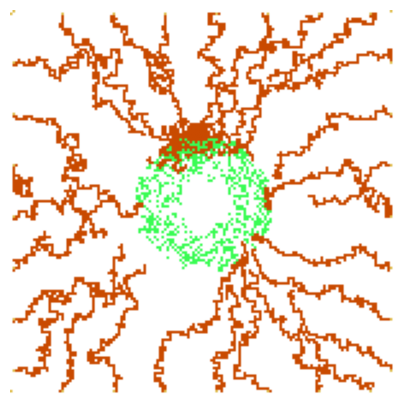

In [16]:
picture = angiogenesisModel.getPicture(tipCellPositions, proliferatingPositions, angiogenesisModel.occupiedCells)

plt.figure(figsize = (5,5))
plt.imshow(picture)
plt.axis("off")
#tikzplotlib.save("tikz_pictures/automaton_angiogenesis.tex")

### 2.- Example angiogenesis network graph 

100%|███████████████████████████████████████| 940/940 [00:00<00:00, 1409.85it/s]


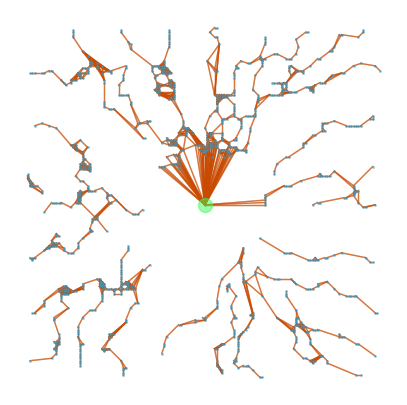

In [17]:
automatonToGraph = AutomatonToGraph()
bloodVesselNetwork = automatonToGraph.convertAutomatonToGraphWithTumor(angiogenesisModel.occupiedCells, proliferatingPositions)

plt.figure(figsize = (5,5))
bloodVesselNetwork.drawGraph(1,plt.gca(),GraphSketchType.ORIGINAL)
plt.axis('off')
#plt.gca().invert_yaxis()
plt.savefig('graph_angiogenesis.pdf',bbox_inches='tight')
#tikzplotlib.save("tikz_pictures/graph_angiogenesis.tex")


### 3.- Example post-angiogenesis growth automaton pictures (no therapy)

In [5]:
nSlices = 6
nEvolutionSteps = 300
frameIndexes = []
currentIndex = 0
indexDelta = int(nEvolutionSteps/nSlices)

for i in range(0,nSlices):
    currentIndex = currentIndex + indexDelta
    frameIndexes.append(300+currentIndex)
    

print(currentIndex)
    

#Load the network 
bloodVesselNetwork = AngiogenesisModel(automatonWidth, automatonHeight)
bloodVesselNetwork = bloodVesselNetwork.openBloodVesselNetworkInstance("network_instance.pkl")

#Load the tumor
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance("tumor_instance.pkl")
tumor.colorVessels = [201/255, 74/255, 0/255]

#Modify nutrient conditions with the blood vessels and grow the tumor to simulate
#cancer progression after angiogenesis
tumor.initializeNutrientWithBloodVessels(bloodVesselNetwork.occupiedCells)
tumor.continueTissueEvolutionWithMovie(nEvolutionSteps, True)


300


100%|█████████████████████████████████████████| 300/300 [00:45<00:00,  6.61it/s]


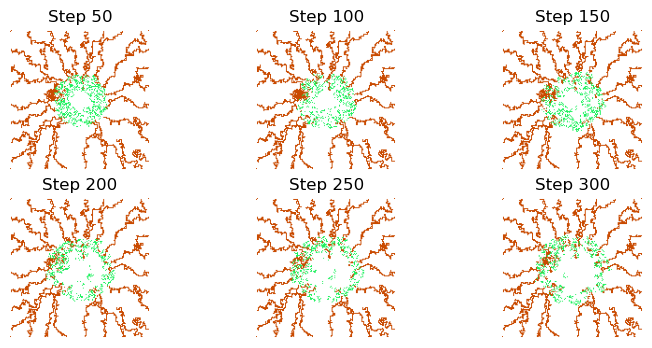

In [6]:
#Draw different steps of the evolution
slices = tumor.evolutionMovie

proliferatingValue = CellType.PROLIFERATING.value
bloodVesselValue = tumor.colorVessels
backgroundValue = [1,1,1]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]
    
    for s in range(0,np.size(frame, 0)):
        for l in range(0, np.size(frame, 1)):
            colorTriplet = frame[s,l,:]
            
            if(not (all(colorTriplet == proliferatingValue) or all(colorTriplet == bloodVesselValue))):
                frame[s,l,:] = backgroundValue
    
    
    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 300 ))



#tikzplotlib.save("tikz_pictures/tumor_growth_automaton_example.tex")
    



### 4.- Example post-angiogenesis growth automaton pictures (radiotherapy)

In [7]:
#Define the therapy 
startDay = 301
g0Gamma = 0.05
alpha = 0.1
beta = 0.05
cycleTime = 4
dose = 1
thresholdOxygen = 0.35
delayTime = 50
initMitoticProb = 0.2
finalMitoticProb = 0.5

radiotherapy = Therapy(TherapyType.RADIOTHERAPY, startDay, g0Gamma, alpha, beta, cycleTime, dose, thresholdOxygen, delayTime, initMitoticProb, finalMitoticProb)

In [8]:
#Graow the tumor with the therapy
nSlices = 6
nEvolutionSteps = 300
frameIndexes = []
currentIndex = 0
indexDelta = int(nEvolutionSteps/nSlices)

for i in range(0,nSlices):
    currentIndex = currentIndex + indexDelta
    frameIndexes.append(300+currentIndex)
    

print(currentIndex)
    

#Load the network 
bloodVesselNetwork = AngiogenesisModel(automatonWidth, automatonHeight)
bloodVesselNetwork = bloodVesselNetwork.openBloodVesselNetworkInstance("network_instance.pkl")

#Load the tumor
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance("tumor_instance.pkl")
tumor.colorVessels = [201/255, 74/255, 0/255]
tumor.addTherapy(radiotherapy)

#Grow the tumor
tumor.initializeNutrientWithBloodVessels(bloodVesselNetwork.occupiedCells)
tumor.continueTissueEvolutionWithMovie(nEvolutionSteps, True)



300


100%|█████████████████████████████████████████| 300/300 [00:43<00:00,  6.97it/s]


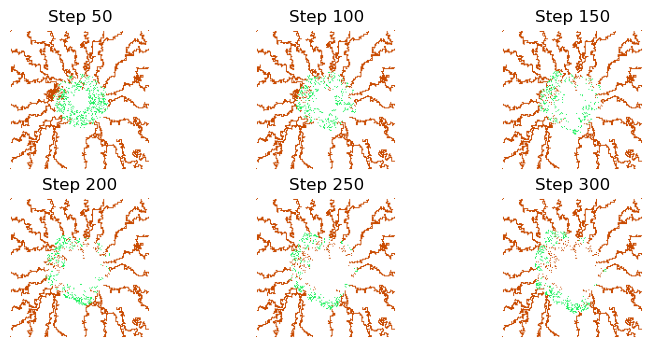

In [9]:
slices = tumor.evolutionMovie

proliferatingValue = CellType.PROLIFERATING.value
bloodVesselValue = tumor.colorVessels
backgroundValue = [1,1,1]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]
    
    for s in range(0,np.size(frame, 0)):
        for l in range(0, np.size(frame, 1)):
            colorTriplet = frame[s,l,:]
            
            if(not (all(colorTriplet == proliferatingValue) or all(colorTriplet == bloodVesselValue))):
                frame[s,l,:] = backgroundValue
    
    
    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 300 ))



#tikzplotlib.save("tikz_pictures/radiotherapy_automaton_example.tex")
    

### 5.- Example post-angiogenesis growth automaton pictures (VDA therapy)

In [10]:
def readCSVColumn(path, colNum):
    colData = []
    
    with open(path, 'r') as file:
        csvreader = csv.reader(file)
        i = 0
        for row in csvreader:
            if(i > 0):
                colData.append(float(row[colNum]))
            i = i + 1
    
    return colData

#### VDA therapy targetting nodes with maximum values for the metric

In [11]:
networkToTreat = 0
networkPath = "bloodvessel_objects/" + "network_"+str(networkToTreat)+".pkl"
networkMetricsSrc = "network_metrics/"+"network_"+str(networkToTreat)+".csv"
nAttackedNodes = 10

automatonWidth = 150
automatonHeight = 150

tumorPath = "tumor_instance.pkl"

#Open the tumor and register the proliferating positions
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance(tumorPath)

tumorEvolutionSteps = 300

proliferatingPositions = np.zeros((automatonHeight, automatonWidth))
tumorSlices = tumor.evolutionMovie
finalSlice = tumorSlices[:,:,:,-1]
for i in range(0,automatonHeight):
    for j in range(0,automatonWidth):
        if((finalSlice[i,j,:] == CellType.PROLIFERATING.value).all()):
            proliferatingPositions[i,j] = 1

            
#Nodes with max degree centrality
metricIndex = 0
    
#Open the network
bloodVesselAutomaton = AngiogenesisModel(automatonWidth, automatonHeight)
bloodVesselAutomaton = bloodVesselAutomaton.openBloodVesselNetworkInstance(networkPath)
bloodVesselPositions = bloodVesselAutomaton.occupiedCells
    
#Turn it into a graph
automatonTransformer = AutomatonToGraph()
bloodVesselGraph = automatonTransformer.convertAutomatonToGraphWithTumor(bloodVesselPositions, proliferatingPositions)
    
#Design the therapy using the nodes to target
nodeNumbersToTarget = readCSVColumn(networkMetricsSrc, metricIndex)
nodeNumbersToTarget = nodeNumbersToTarget[0:nAttackedNodes]
    
    
locationsToTreat = np.zeros((automatonHeight, automatonWidth))
for j in range(0,len(nodeNumbersToTarget)):
    nodeIndex = nodeNumbersToTarget[j]
    node = bloodVesselGraph.nodes[int(nodeIndex)]
    automatonIndex1 = node.automatonIndex1
    automatonIndex2 = node.automatonIndex2
    locationsToTreat[automatonIndex1, automatonIndex2] = 1
        
    
startDay = 301
vesselKillThreshold = 0.065
potentialConstant = 1
sourceAmplification = 2
stepDeathProbability = 0.01
    
angioTherapy = Therapy(TherapyType.ANGIOTHERAPY, startDay, locationsToTreat, vesselKillThreshold, potentialConstant, sourceAmplification, stepDeathProbability)
    
tumor.initializeNutrientWithBloodVessels(bloodVesselPositions)
tumor.addTherapy(angioTherapy)
tumor.colorVessels = [201/255, 74/255, 0/255]
tumor.continueTissueEvolutionWithMovie(tumorEvolutionSteps, False)


100%|█████████████████████████████████████████| 300/300 [00:45<00:00,  6.63it/s]


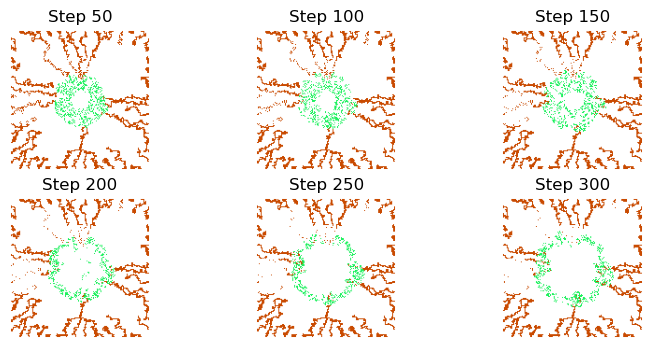

In [12]:
slices = tumor.evolutionMovie

proliferatingValue = CellType.PROLIFERATING.value
bloodVesselValue = tumor.colorVessels
backgroundValue = [1,1,1]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]
    
    for s in range(0,np.size(frame, 0)):
        for l in range(0, np.size(frame, 1)):
            colorTriplet = frame[s,l,:]
            
            if(not (all(colorTriplet == proliferatingValue) or all(colorTriplet == bloodVesselValue))):
                frame[s,l,:] = backgroundValue
    
    
    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 300))



#tikzplotlib.save("tikz_pictures/antio_angiogenic_automaton_example_max.tex")

#### VDA therapy targetting nodes with minimumvalues for the metric

In [13]:
networkToTreat = 0
networkPath = "bloodvessel_objects/" + "network_"+str(networkToTreat)+".pkl"
networkMetricsSrc = "network_metrics/"+"network_"+str(networkToTreat)+".csv"
nAttackedNodes = 10

automatonWidth = 150
automatonHeight = 150

tumorPath = "tumor_instance.pkl"

#Open the tumor and register the proliferating positions
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance(tumorPath)

tumorEvolutionSteps = 300

proliferatingPositions = np.zeros((automatonHeight, automatonWidth))
tumorSlices = tumor.evolutionMovie
finalSlice = tumorSlices[:,:,:,-1]
for i in range(0,automatonHeight):
    for j in range(0,automatonWidth):
        if((finalSlice[i,j,:] == CellType.PROLIFERATING.value).all()):
            proliferatingPositions[i,j] = 1

            
#Nodes with max degree centrality
metricIndex = 5
    
#Open the network
bloodVesselAutomaton = AngiogenesisModel(automatonWidth, automatonHeight)
bloodVesselAutomaton = bloodVesselAutomaton.openBloodVesselNetworkInstance(networkPath)
bloodVesselPositions = bloodVesselAutomaton.occupiedCells
    
#Turn it into a graph
automatonTransformer = AutomatonToGraph()
bloodVesselGraph = automatonTransformer.convertAutomatonToGraphWithTumor(bloodVesselPositions, proliferatingPositions)
    
#Design the therapy using the nodes to target
nodeNumbersToTarget = readCSVColumn(networkMetricsSrc, metricIndex)
nodeNumbersToTarget = nodeNumbersToTarget[0:nAttackedNodes]
    
    
locationsToTreat = np.zeros((automatonHeight, automatonWidth))
for j in range(0,len(nodeNumbersToTarget)):
    nodeIndex = nodeNumbersToTarget[j]
    node = bloodVesselGraph.nodes[int(nodeIndex)]
    automatonIndex1 = node.automatonIndex1
    automatonIndex2 = node.automatonIndex2
    locationsToTreat[automatonIndex1, automatonIndex2] = 1
        
    
startDay = 301
vesselKillThreshold = 0.065
potentialConstant = 1
sourceAmplification = 2
stepDeathProbability = 0.01
    
angioTherapy = Therapy(TherapyType.ANGIOTHERAPY, startDay, locationsToTreat, vesselKillThreshold, potentialConstant, sourceAmplification, stepDeathProbability)
    
tumor.initializeNutrientWithBloodVessels(bloodVesselPositions)
tumor.addTherapy(angioTherapy)
tumor.colorVessels = [201/255, 74/255, 0/255]
tumor.continueTissueEvolutionWithMovie(tumorEvolutionSteps, False)


100%|█████████████████████████████████████████| 300/300 [00:46<00:00,  6.44it/s]


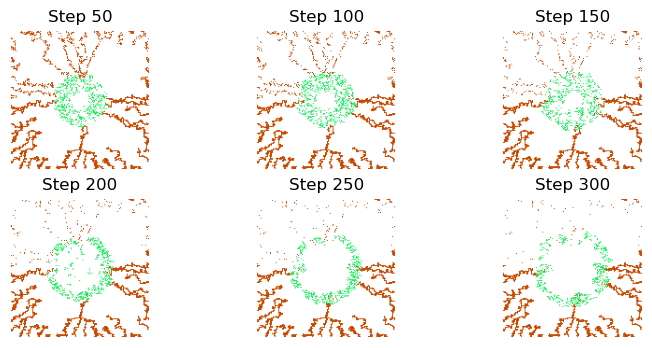

In [14]:
slices = tumor.evolutionMovie

proliferatingValue = CellType.PROLIFERATING.value
bloodVesselValue = tumor.colorVessels
backgroundValue = [1,1,1]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]
    
    for s in range(0,np.size(frame, 0)):
        for l in range(0, np.size(frame, 1)):
            colorTriplet = frame[s,l,:]
            
            if(not (all(colorTriplet == proliferatingValue) or all(colorTriplet == bloodVesselValue))):
                frame[s,l,:] = backgroundValue
    
    
    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 300 ))



#tikzplotlib.save("tikz_pictures/antio_angiogenic_automaton_example_min.tex")